In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'D:\\FAST.Ai\\Practical Deep Learning For Coders 1 - YouTube\\Data\\understanding amazon\\planet\\'

In [4]:
os.listdir(PATH)


['models', 'test-jpg', 'tmp', 'train-jpg', 'train_v2.csv', 'train_v2.xlsx']

In [5]:
from fastai.plots import *

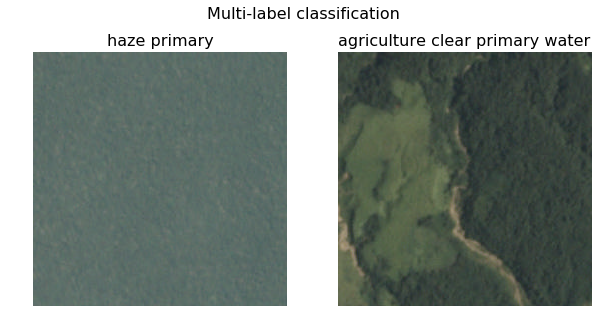

In [6]:
list_paths = [f"{PATH}train-jpg\\train_0.jpg", f"{PATH}train-jpg\\train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [ ]:
#!pip install planet

In [18]:
from planet import *

In [19]:
#from planet import f2

ImportError: cannot import name 'f2'

In [20]:
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average='samples')
                for th in ths])
    return ths[idx]

def get_data(path, tfms,bs,  n, cv_idx):
    val_idxs = get_cv_idxs(n, cv_idx)
    return ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, tfms,
                                 suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

def get_data_zoom(f_model, path, sz, bs, n, cv_idx):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return get_data(path, tfms, bs, n, cv_idx)

def get_data_pad(f_model, path, sz, bs, n, cv_idx):
    transforms_pt = [RandomRotateZoom(9, 0.18, 0.1), RandomLighting(0.05, 0.1), RandomDihedral()]
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_pt, pad=sz//12)
    return get_data(path, tfms, bs, n, cv_idx)

In [24]:
metrics=[f2]
f_model = resnet34

In [25]:
label_csv = f'{PATH}train_v2.csv'

In [26]:
n = len(list(open(label_csv))) - 1

In [27]:
val_idxs = get_cv_idxs(n)

In [28]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [29]:
sz = 64
data = get_data(sz)

In [14]:
x,y = next(iter(data.val_dl))

In [15]:
list(zip(y[40],data.classes))

[(1.0, 'agriculture'),
 (0.0, 'artisinal_mine'),
 (0.0, 'bare_ground'),
 (0.0, 'blooming'),
 (0.0, 'blow_down'),
 (1.0, 'clear'),
 (0.0, 'cloudy'),
 (0.0, 'conventional_mine'),
 (1.0, 'cultivation'),
 (0.0, 'habitation'),
 (0.0, 'haze'),
 (0.0, 'partly_cloudy'),
 (1.0, 'primary'),
 (0.0, 'road'),
 (0.0, 'selective_logging'),
 (0.0, 'slash_burn'),
 (0.0, 'water')]

In [16]:
x.type()

'torch.FloatTensor'

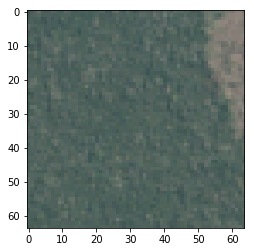

In [17]:
plt.imshow(data.val_ds.denorm(to_np(x))[40] * 1.4)

In [31]:
data.resize(int(sz*1.3) , 'tmp') # it just save time , not allowing photoes bigger than sz*1.3 to go in our data 
#, photoes are rectangle(mitone toolesh sz*1.3 bashe arzaes kamtar)
#(center-cropped)

In [32]:
learn = ConvLearner.pretrained(f_model,data,metrics = metrics)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.685843   1.675254   0.730857  



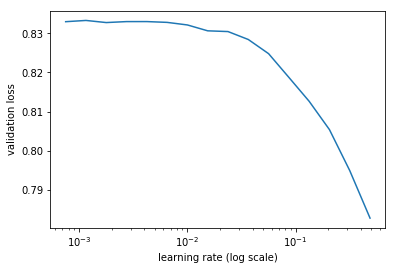

In [34]:
lrf = learn.lr_find()
learn.sched.plot()

In [36]:
lr = 0.2

In [37]:
learn.fit(lr,3,cycle_len = 1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.462274   0.265837   0.815086  
    1      0.284262   0.156192   0.858942                                                                              
    2      0.217367   0.153736   0.861346                                                                              
    3      0.186724   0.146933   0.872973                                                                              
    4      0.170137   0.14112    0.878027                                                                              
    5      0.15808    0.139606   0.881523                                                                              
    6      0.150595   0.139285   0.881019                                                                              



[array([0.13929]), 0.8810189371934245]

In [38]:
lrs = [lr/9 , lr/3 , lr]

In [39]:
learn.unfreeze()
learn.fit(lrs,3,cycle_len = 1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.177761   0.152956   0.872653  
    1      0.156926   0.14483    0.881312                                                                              
    2      0.143243   0.128345   0.895472                                                                              
    3      0.138377   0.12915    0.896719                                                                              
    4      0.129488   0.119693   0.906511                                                                              
    5      0.120924   0.119828   0.904018                                                                              
    6      0.115918   0.118198   0.905522                                                                              



[array([0.1182]), 0.9055219706912973]

In [42]:
learn.save(f'{sz}')

In [43]:
sz=128

In [44]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.122639   0.126052   0.896427  
    1      0.119696   0.120438   0.899883                                                                              
    2      0.115803   0.120641   0.900369                                                                              
 44%|██████████████████████████████▋                                       | 14/32 [01:20<01:34,  5.27s/it, loss=0.115]

KeyboardInterrupt: 

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
multy_preds , y = learn.TTA()
preds = np.mean(multy_preds,0)

In [ ]:
f2(preds,y)